## Final Model Versions Used for Predictions
### Ensemble Equal Weighted Voting made up of
1. Light Gradient Boosting (Hyperparameter Tuned in \Jupyter Notebooks\Hyperparameter Tuning\lgbm-character-ngram-optimization.ipynb)
2. CatBoost (Hyperparameters not tuned due to time constraints. Base model already does well and is a great addition to the ensemble)
3. Neural Network (Hyperparameter Tuned in Hyperparameter Tuned in \Jupyter Notebooks\Hyperparameter Tuning\neural-network-character-ngram-hyperparam.ipynb)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
import warnings
# Ignore scipy warnings as it was intended to convert to sparse matrix below
warnings.filterwarnings("ignore", message="Converting data to scipy sparse matrix.")

In [3]:
import matplotlib.pyplot as plt
import string
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from scipy.sparse import coo_matrix, hstack, vstack
from sklearn import metrics
from xgboost import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from gensim.parsing.preprocessing import remove_stopwords
from lightgbm import LGBMClassifier
import time

In [4]:
train = pd.read_csv("datasets/preprocessed_train.csv")
test = pd.read_csv("datasets/preprocessed_test.csv")

#### Preprocessing steps that we have found to produce the best results
1. Lowercase everything
2. Substitute digits with 1 (normalise digits)

In [5]:
import re
train["Processed"] = train["Comment"].apply(lambda x: re.sub('\d', '1', x.lower()))
test["Processed"] = test["Comment"].apply(lambda x: re.sub('\d', '1', x.lower()))

# LGBM

#### We used TFIDF character level text features with variables from EDA. We also use equal class balance by setting class weight to balanced.

In [6]:
# Helper function to split into train and test sets
def get_train_test_lgbm(train, test = None, ngram_range = (1,1), max_features=None, random_state=1, test_size=0.1, min_df=50):
    
    if type(test) != pd.core.frame.DataFrame:
        # Just to check if test is provided, then we'll do train, test instead
        # of train val split
        X = train.Processed
        y = train.Outcome
        
        # We split by using test_size for y_val
        X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=random_state, test_size=test_size)
        
        # We're using tfidf vectorizer for our analysis, character level model
        tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=ngram_range, max_features=max_features, min_df=min_df)
        
        print("Fitting...")
        start = time.time()
        # Fit transform the training, ONLY on training
        X_train_dtm =  tfidf_vect_ngram_chars.fit_transform(X_train) 
        # Transform the x_val
        X_val_dtm =  tfidf_vect_ngram_chars.transform(X_val) 
        print(f"Operation Took {round(start-time.time(), 2)}s")
        print(X_train_dtm.shape, X_val_dtm.shape)

        # Adding in additional variables from EDA
        add_var_df = train.loc[X_train.index].reset_index()[['num_numbers', 'prop_numbers', 'num_words',
               'num_punctuation', 'prop_punctuation', 'nchar', 'word_density', 'noun_count', 'verb_count', 'adj_count', 'adv_count', 'pron_count']]

        for column in add_var_df.columns:
            var_sparse = add_var_df[column].values[:, None]
            X_train_dtm = hstack((X_train_dtm, var_sparse))

        add_var_df = train.loc[X_val.index].reset_index()[['num_numbers', 'prop_numbers', 'num_words',
               'num_punctuation', 'prop_punctuation', 'nchar', 'word_density', 'noun_count', 'verb_count', 'adj_count', 'adv_count', 'pron_count']]
        for column in add_var_df.columns:
            var_sparse = add_var_df[column].values[:, None]
            X_val_dtm = hstack((X_val_dtm, var_sparse))
        
        print("X_train: ", X_train_dtm.shape)
        print("X_val: ", X_val_dtm.shape)
        
        return X_train_dtm, X_val_dtm, y_train, y_val
    else:
        # We're using tfidf vectorizer for our analysis, character level model
        tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=ngram_range, max_features=max_features, min_df=min_df)

        print("Fitting...")
        start = time.time()
        # Fit transform the training, ONLY on training
        X_train_dtm =  tfidf_vect_ngram_chars.fit_transform(train.Processed)
        # Transform the test comment
        X_test_dtm =  tfidf_vect_ngram_chars.transform(test.Processed) 
        print(f"Operation Took {time.time()-start}s")
        print(X_train_dtm.shape, X_test_dtm.shape)

        # Add in additional variables from EDA
        add_var_df = train[['num_numbers', 'prop_numbers', 'num_words',
               'num_punctuation', 'prop_punctuation', 'nchar', 'word_density', 'noun_count', 'verb_count', 'adj_count', 'adv_count', 'pron_count']]

        for column in add_var_df.columns:
            var_sparse = add_var_df[column].values[:, None]
            X_train_dtm = hstack((X_train_dtm, var_sparse))

        add_var_df = test[['num_numbers', 'prop_numbers', 'num_words',
               'num_punctuation', 'prop_punctuation', 'nchar', 'word_density', 'noun_count', 'verb_count', 'adj_count', 'adv_count', 'pron_count']]
        for column in add_var_df.columns:
            var_sparse = add_var_df[column].values[:, None]
            X_test_dtm = hstack((X_test_dtm, var_sparse))
        
        print(X_train_dtm.shape, X_test_dtm.shape)
        
        print("X_train: ", X_train_dtm.shape)
        print("X_test: ", X_test_dtm.shape)
        
        return X_train_dtm, X_test_dtm, train.Outcome

In [7]:
# Hyperparameters from hyperopt bayesian optimisation
lg_params = {'boosting_type': 'gbdt',
 'class_weight': 'balanced',
 'colsample_bytree': 0.6370495458782991,
 'learning_rate': 0.1,
 'max_depth': 200,
 'metric': 'auc',
 'min_child_samples': 20,
 'n_estimators': 200,
 'num_leaves': 25,
 'objective': 'binary',
 'random_state': 1234,
 'reg_alpha': 0.0720812229772364,
 'reg_lambda': 1.87246159415014}

In [8]:
start = time.time()
X_train, X_val, y_train, y_val = get_train_test_lgbm(train, test = None, ngram_range = (2,5), 
                    max_features=None, random_state=1, test_size=0.1, min_df = 50)

LG = LGBMClassifier(**lg_params)
%time LG.fit(X_train, y_train)

Fitting...
Operation Took -172.03s
(40013, 91675) (4446, 91675)
X_train:  (40013, 91687)
X_val:  (4446, 91687)
CPU times: user 47min 29s, sys: 11.1 s, total: 47min 40s
Wall time: 12min 51s


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=0.6370495458782991, importance_type='split',
               learning_rate=0.1, max_depth=200, metric='auc',
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=200, n_jobs=-1, num_leaves=25, objective='binary',
               random_state=1234, reg_alpha=0.0720812229772364,
               reg_lambda=1.87246159415014, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [9]:
from sklearn import metrics
print("Train")
y_pred_class = LG.predict(X_train)
# Comparison between vanilla roc_auc using predict vs if we use predict_proba
print("Accuracy: ", metrics.accuracy_score(y_train, y_pred_class))
print("Auroc: ", metrics.roc_auc_score(y_train, y_pred_class))
y_pred_class = LG.predict_proba(X_train)
print("Auroc: ", metrics.roc_auc_score(y_train, y_pred_class[:, 1]))

print("Validation")
y_pred_class = LG.predict(X_val)
print("Accuracy: ", metrics.accuracy_score(y_val, y_pred_class))
print("Auroc: ", metrics.roc_auc_score(y_val, y_pred_class))
y_pred_class_lgbm = LG.predict_proba(X_val)[:, 1]
print("Auroc: ", metrics.roc_auc_score(y_val, y_pred_class_lgbm))
end = time.time() - start
print(f"Entire Process Took {round(end,2)}seconds")

Train
Accuracy:  0.8379776572613901
Auroc:  0.8403213086306742
Auroc:  0.9223882591130996
Validation
Accuracy:  0.7359424201529464
Auroc:  0.7362648826640202
Auroc:  0.8153892245016547
Entire Process Took 968.2seconds


#### Obtains 0.815 AUROC on Validation Set

# Neural Network

#### Note: Only tfidf was used, with no other features such as num words as there were time constraints. Including other variables from EDA and scaling could have been a hyperparameter to tune as well for further improvements. Since tfidf is already in a way scaled, I did not scale anything. We also use equal class balance by over sampling.

In [10]:
def get_train_test_nn(train, test = None, ngram_range = (1,1), max_features=None, random_state=1, test_size=0.1, min_df=50):
    
    if type(test) != pd.core.frame.DataFrame:
        
        X = train.Processed
        y = train.Outcome
        
        X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=random_state, test_size=test_size)
        
        tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=ngram_range, max_features=max_features, min_df=min_df)

        print("Fitting...")
        start = time.time()
        X_train_dtm =  tfidf_vect_ngram_chars.fit_transform(X_train) 
        X_val_dtm =  tfidf_vect_ngram_chars.transform(X_val) 
        print(f"Operation Took {round(start-time.time(), 2)}s")
        
        # Neural network needs to oversample
        from imblearn.over_sampling import RandomOverSampler
        ros = RandomOverSampler(random_state=0)
        X_train_dtm, y_train = ros.fit_resample(X_train_dtm, y_train)
        
        print("X_train: ", X_train_dtm.shape)
        print("X_val: ", X_val_dtm.shape)
        
        return X_train_dtm, X_val_dtm, y_train, y_val
    else:
        tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=ngram_range, max_features=max_features, min_df=min_df)

        print("Fitting...")
        start = time.time()
        X_train_dtm =  tfidf_vect_ngram_chars.fit_transform(train.Processed) 
        X_test_dtm =  tfidf_vect_ngram_chars.transform(test.Processed) 
        print(f"Operation Took {time.time()-start}s")
        print(X_train_dtm.shape, X_test_dtm.shape)
        
        # For neural network, need to oversample
        from imblearn.over_sampling import RandomOverSampler
        ros = RandomOverSampler(random_state=0)
        X_train_dtm, y_train = ros.fit_resample(X_train_dtm, train.Outcome)
    
        print("X_train: ", X_train_dtm.shape)
        print("X_test: ", X_test_dtm.shape)
        
        return X_train_dtm, X_test_dtm, y_train

In [11]:
from __future__ import division
import numpy as np

# Function to help plot out the histroy of the epochs and results on train and validation sets
def plot_history(history):
    # Plot loss and accuracy 
    fig = plt.figure(figsize=(10,5))

    #plt.subplot(1, 2, 1)
    plt.plot(history.epoch, history.history['val_loss'], 'g-', label='Validation data')
    plt.plot(history.epoch, history.history['loss'], 'r--', label='Training data')
    plt.grid(True)
    plt.xlabel('Number of epochs')
    plt.ylabel('Loss on training/validation data')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

    #plt.subplot(1, 2, 2)
    fig = plt.figure(figsize=(10,5))
    plt.plot(history.epoch, history.history['val_accuracy'], 'g-', label='Validation data')
    plt.plot(history.epoch, history.history['accuracy'], 'r--', label='Training data')
    plt.grid(True)
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy on training/validation data')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

In [12]:
start = time.time()
X_train, X_val, y_train, y_val = get_train_test_nn(train, test = None, ngram_range = (2,5), 
                    max_features=None, random_state=1, test_size=0.1, min_df=50)

Fitting...
Operation Took -200.84s


Using TensorFlow backend.


X_train:  (45028, 91675)
X_val:  (4446, 91675)


### Neural Network using one dense layer with 10 units, relu activation and 0.6 dropout

Train on 45028 samples, validate on 4446 samples
Epoch 1/5
 - 81s - loss: 0.6453 - accuracy: 0.6436 - val_loss: 0.5935 - val_accuracy: 0.7197
Epoch 2/5
 - 81s - loss: 0.5710 - accuracy: 0.7242 - val_loss: 0.5533 - val_accuracy: 0.7287
Epoch 3/5
 - 82s - loss: 0.5264 - accuracy: 0.7560 - val_loss: 0.5356 - val_accuracy: 0.7314
Epoch 4/5
 - 80s - loss: 0.4936 - accuracy: 0.7776 - val_loss: 0.5264 - val_accuracy: 0.7371
Epoch 5/5
 - 79s - loss: 0.4642 - accuracy: 0.7993 - val_loss: 0.5218 - val_accuracy: 0.7382


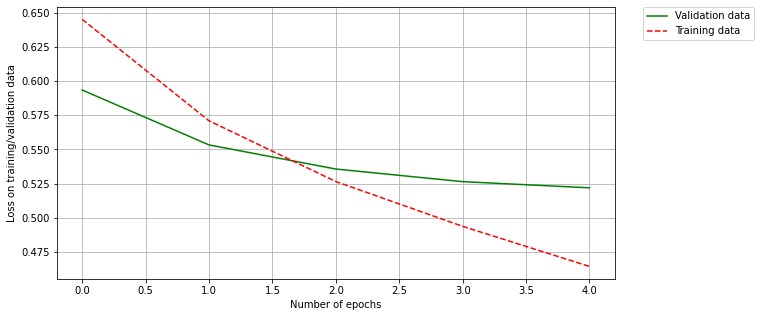

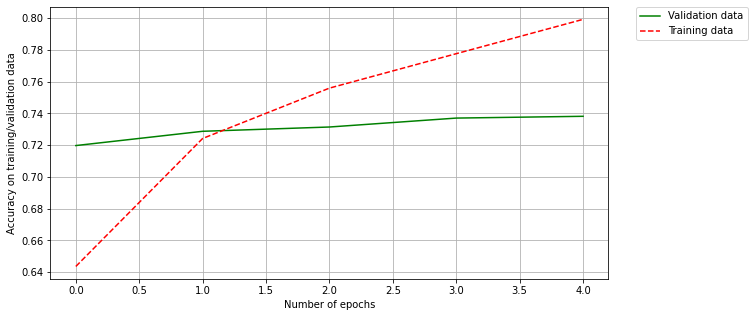

In [13]:
from numpy.random import seed
seed(1)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
import keras
from keras.layers.advanced_activations import LeakyReLU, PReLU
# define network
model = Sequential()
model.add(Dense(10, input_shape=(X_train.shape[1],), activation="linear",
                kernel_initializer=keras.initializers.he_normal(seed=1)))
model.add(Activation('relu'))

#model.add(LeakyReLU(alpha=.3))
model.add(Dropout(0.6))
model.add(Dense(1, activation='sigmoid'))
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=5, verbose=2, validation_data=(X_val, y_val), batch_size = 256)
plot_history(history)

In [14]:
print("Train")
y_pred_class = model.predict_proba(X_train)
print("Accuracy: ", metrics.accuracy_score(y_train, y_pred_class.round().astype('int')))
y_pred_class = model.predict_proba(X_train)
print("Auroc: ", metrics.roc_auc_score(y_train, y_pred_class))

print("Validation")
y_pred_class = model.predict(X_val)
print("Accuracy: ", metrics.accuracy_score(y_val, y_pred_class.round().astype('int')))
y_pred_class_nn = model.predict_proba(X_val)
print("Auroc: ", metrics.roc_auc_score(y_val, y_pred_class_nn))

Train
Accuracy:  0.8556897930176779
Auroc:  0.9284301590666209
Validation
Accuracy:  0.738191632928475
Auroc:  0.8141727468259337


#### Obtains 0.814 AUROC on Validation Set

# Catboost

#### For catboost, we use a different preprocessing. We use CountVectorizer, and set binary=True for where we have the text or not. This is so that we can put these in as the categorical variables, hopefully getting a result that is not so correlated with LGBM. We also use equal class balance.

In [15]:
# Helper function to get train, val and test data
def get_train_test_cbc(train, test = None, ngram_range = (1,1), max_features=None, random_state=1, test_size=0.1, min_df=50):
    
    if type(test) != pd.core.frame.DataFrame:
        # To check if we want to split into train val, or train test
        
        # Use only the train data for train val split
        X = train.Processed
        y = train.Outcome
        
        # split into train and test set, using random_state so that it is reproducable
        X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=random_state, test_size=test_size)
        
        # We use count vect character level analyser
        # Binary set to true
        count_vect_ngram_chars = CountVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=ngram_range, max_features=max_features, min_df=min_df, binary = True)

        print("Fitting...")
        start = time.time()
        # Fit transform only on the train set, use it to transform the val set
        X_train_dtm =  count_vect_ngram_chars.fit_transform(X_train) 
        X_val_dtm =  count_vect_ngram_chars.transform(X_val) 
        print(f"Operation Took {round(start-time.time(), 2)}s")
        print(X_train_dtm.shape, X_val_dtm.shape)

        # Next, we need to add in the other variables from EDA, need to use scipy to maintain the sparse matrix or we will run out of memory
        add_var_df = train.loc[X_train.index].reset_index()[['num_numbers', 'prop_numbers', 'num_words',
               'num_punctuation', 'prop_punctuation', 'nchar', 'word_density', 'noun_count', 'verb_count', 'adj_count', 'adv_count', 'pron_count']]

        for column in add_var_df.columns:
            var_sparse = add_var_df[column].values[:, None]
            # Stacks horizontally, effectively increasing columns of features to include our EDA
            X_train_dtm = hstack((X_train_dtm, var_sparse))

        # Repeat the same for the validation set
        add_var_df = train.loc[X_val.index].reset_index()[['num_numbers', 'prop_numbers', 'num_words',
               'num_punctuation', 'prop_punctuation', 'nchar', 'word_density', 'noun_count', 'verb_count', 'adj_count', 'adv_count', 'pron_count']]
        for column in add_var_df.columns:
            var_sparse = add_var_df[column].values[:, None]
            X_val_dtm = hstack((X_val_dtm, var_sparse))
        
        print("X_train: ", X_train_dtm.shape)
        print("X_val: ", X_val_dtm.shape)
        
        return X_train_dtm.tocsr().astype(np.int8), X_val_dtm.tocsr().astype(np.int8), y_train, y_val
    else:
        # We use ccount vect character level analyser
        # Binary set to true
        count_vect_ngram_chars = CountVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=ngram_range, max_features=max_features, min_df=min_df, binary = True)

        print("Fitting...")
        start = time.time()
        # Fit on train, transform train and test
        X_train_dtm =  count_vect_ngram_chars.fit_transform(train.Processed) 
        X_test_dtm =  count_vect_ngram_chars.transform(test.Processed) 
        print(f"Operation Took {time.time()-start}s")
        print(X_train_dtm.shape, X_test_dtm.shape)

        # Next, we need to add in the other variables from EDA, need to use scipy to maintain the sparse matrix or we will run out of memory
        add_var_df = train[['num_numbers', 'prop_numbers', 'num_words',
               'num_punctuation', 'prop_punctuation', 'nchar', 'word_density', 'noun_count', 'verb_count', 'adj_count', 'adv_count', 'pron_count']]

        for column in add_var_df.columns:
            var_sparse = add_var_df[column].values[:, None]
            # Stacks horizontally, effectively increasing columns of features to include our EDA
            X_train_dtm = hstack((X_train_dtm, var_sparse))

        # Repeat the same for the test set
        add_var_df = test[['num_numbers', 'prop_numbers', 'num_words',
               'num_punctuation', 'prop_punctuation', 'nchar', 'word_density', 'noun_count', 'verb_count', 'adj_count', 'adv_count', 'pron_count']]
        for column in add_var_df.columns:
            var_sparse = add_var_df[column].values[:, None]
            X_test_dtm = hstack((X_test_dtm, var_sparse))
        
        print(X_train_dtm.shape, X_test_dtm.shape)
        
        print("X_train: ", X_train_dtm.shape)
        print("X_test: ", X_test_dtm.shape)
        
        return X_train_dtm.tocsr().astype(np.int8), X_test_dtm.tocsr().astype(np.int8), train.Outcome

In [16]:
start = time.time()
X_train, X_val, y_train, y_val = get_train_test_cbc(train, test = None, ngram_range = (2,5), 
                    max_features=None, random_state=1, test_size=0.1, min_df=50)
cat_feat = X_train.shape[1] - 12

Fitting...
Operation Took -190.95s
(40013, 91675) (4446, 91675)
X_train:  (40013, 91687)
X_val:  (4446, 91687)


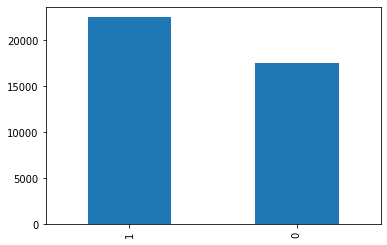

In [17]:
y_train.value_counts().plot(kind="bar")

In [18]:
from catboost import CatBoostClassifier
# For equal class balance.
zero_weight = y_train.value_counts().loc[1]/y_train.value_counts().loc[0]
one_weight = 1
CBC = CatBoostClassifier(cat_features=list(range(cat_feat)), class_weights=[zero_weight, one_weight], 
                         loss_function='Logloss',eval_metric='AUC', verbose=0)
%time CBC.fit(X_train, y_train)

CPU times: user 2h 25min 54s, sys: 2min 30s, total: 2h 28min 24s
Wall time: 45min 2s


In [19]:
from sklearn import metrics
print("Train")
y_pred_class = CBC.predict(X_train)
# Comparison between vanilla roc_auc using predict vs if we use predict_proba
print("Accuracy: ", metrics.accuracy_score(y_train, y_pred_class))
print("Auroc: ", metrics.roc_auc_score(y_train, y_pred_class))
y_pred_class = CBC.predict_proba(X_train)
print("Auroc: ", metrics.roc_auc_score(y_train, y_pred_class[:, 1]))

print("Validation")
y_pred_class = CBC.predict(X_val)
print("Accuracy: ", metrics.accuracy_score(y_val, y_pred_class))
print("Auroc: ", metrics.roc_auc_score(y_val, y_pred_class))
y_pred_class_cbc = CBC.predict_proba(X_val)[:, 1]
print("Auroc: ", metrics.roc_auc_score(y_val, y_pred_class_cbc))
end = time.time() - start
print(f"Entire Process Took {round(end,2)}seconds")

Train
Accuracy:  0.8078374528278309
Auroc:  0.812786944213155
Auroc:  0.9003722546756728
Validation
Accuracy:  0.728969860548808
Auroc:  0.7325587616125571
Auroc:  0.8124488547475861
Entire Process Took 3050.64seconds


#### Obtains 0.812 AUROC on Validation Set

# Equal Weight Ensemble
Here, we try out different combinations of the predictions to see what does the best!

In [20]:
y_pred_all = (y_pred_class_nn[:, 0] + y_pred_class_lgbm) / 2
print("Auroc ANN: ", metrics.roc_auc_score(y_val, y_pred_class_nn))
print("Auroc LGB: ", metrics.roc_auc_score(y_val, y_pred_class_lgbm))
print("Auroc Ensemble: ", metrics.roc_auc_score(y_val, y_pred_all))

Auroc ANN:  0.8141727468259337
Auroc LGB:  0.8153892245016547
Auroc Ensemble:  0.8266292971528619


In [21]:
y_pred_all = (y_pred_class_cbc + y_pred_class_lgbm) / 2
print("Auroc CBC: ", metrics.roc_auc_score(y_val, y_pred_class_cbc))
print("Auroc LGB: ", metrics.roc_auc_score(y_val, y_pred_class_lgbm))
print("Auroc Ensemble: ", metrics.roc_auc_score(y_val, y_pred_all))

Auroc CBC:  0.8124488547475861
Auroc LGB:  0.8153892245016547
Auroc Ensemble:  0.8188524409698652


In [22]:
y_pred_all = (y_pred_class_cbc + y_pred_class_nn[:, 0]) / 2
print("Auroc CBC: ", metrics.roc_auc_score(y_val, y_pred_class_cbc))
print("Auroc ANN: ", metrics.roc_auc_score(y_val, y_pred_class_nn))
print("Auroc Ensemble: ", metrics.roc_auc_score(y_val, y_pred_all))

Auroc CBC:  0.8124488547475861
Auroc ANN:  0.8141727468259337
Auroc Ensemble:  0.8263461656775928


In [23]:
y_pred_all = (y_pred_class_cbc + y_pred_class_nn[:, 0] + y_pred_class_lgbm) / 3
print("Auroc CBC: ", metrics.roc_auc_score(y_val, y_pred_class_cbc))
print("Auroc ANN: ", metrics.roc_auc_score(y_val, y_pred_class_nn))
print("Auroc LGB: ", metrics.roc_auc_score(y_val, y_pred_class_lgbm))
print("Auroc Ensemble: ", metrics.roc_auc_score(y_val, y_pred_all))

Auroc CBC:  0.8124488547475861
Auroc ANN:  0.8141727468259337
Auroc LGB:  0.8153892245016547
Auroc Ensemble:  0.8277412466385854


In [24]:
results = pd.DataFrame([y_pred_class_cbc, y_pred_class_nn[:, 0], y_pred_class_lgbm]).T
results.columns = ["CatBoost", "Neural Network", "Light Gradient Boosting"]
results.head()

,CatBoost,Neural Network,Light Gradient Boosting
0,0.590444,0.809272,0.582764
1,0.799205,0.477478,0.758261
2,0.669247,0.699266,0.521327
3,0.387787,0.617315,0.673890
4,0.613138,0.749284,0.842190


Text(0.5, 1.0, 'Prediction Correlations')

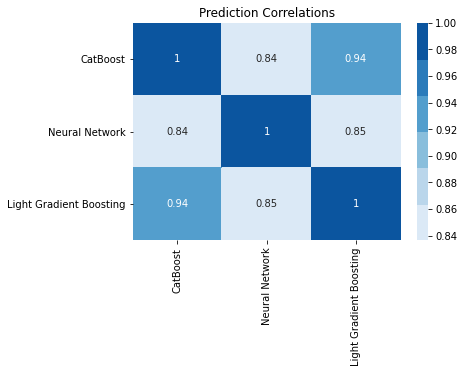

In [25]:
import seaborn as sns
sns.heatmap(results.corr(), annot = True, cmap=sns.color_palette("Blues"))
plt.title("Prediction Correlations")

# I concluded that adding in all three models were beneficial as it results in the highest validation AUC score.

# Final Predictions
### Repeat of the above models using train and test set

In [26]:
X_train, X_test, y_train = get_train_test_lgbm(train, test = test, ngram_range = (2,5), 
                    max_features=None, random_state=1, test_size=0.1, min_df = 50)

LG = LGBMClassifier(**lg_params)
%time LG.fit(X_train, y_train)
final_pred_lgbm = LG.predict_proba(X_test)[:, 1]

Fitting...
Operation Took 283.35865783691406s
(44459, 98368) (27924, 98368)
(44459, 98380) (27924, 98380)
X_train:  (44459, 98380)
X_test:  (27924, 98380)
CPU times: user 46min 32s, sys: 10.1 s, total: 46min 42s
Wall time: 12min 43s


In [27]:
X_train, X_test, y_train = get_train_test_nn(train, test = test, ngram_range = (2,5), 
                    max_features=None, random_state=1, test_size=0.1, min_df=50)

seed(1)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
import keras
from keras.layers.advanced_activations import LeakyReLU, PReLU
# define network
model = Sequential()
model.add(Dense(10, input_shape=(X_train.shape[1],), activation="linear",
                kernel_initializer=keras.initializers.he_normal(seed=1)))
model.add(Activation('relu'))
#model.add(LeakyReLU(alpha=.3))
model.add(Dropout(0.6))
model.add(Dense(1, activation='sigmoid'))
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=5, verbose=2, batch_size = 256)
final_pred_nn = model.predict_proba(X_test)[:, 0] # For nn, 0 instead of 1

Fitting...
Operation Took 299.6214461326599s
(44459, 98368) (27924, 98368)
X_train:  (50046, 98368)
X_test:  (27924, 98368)
Epoch 1/5
 - 77s - loss: 0.6324 - accuracy: 0.6543
Epoch 2/5
 - 77s - loss: 0.5589 - accuracy: 0.7278
Epoch 3/5
 - 77s - loss: 0.5125 - accuracy: 0.7644
Epoch 4/5
 - 77s - loss: 0.4812 - accuracy: 0.7838
Epoch 5/5
 - 77s - loss: 0.4517 - accuracy: 0.8024


In [28]:
X_train, X_test, y_train = get_train_test_cbc(train, test = test, ngram_range = (2,5), 
                    max_features=None, random_state=1, test_size=0.1, min_df=50)
cat_feat = X_train.shape[1] - 12
zero_weight = y_train.value_counts().loc[1]/y_train.value_counts().loc[0]
one_weight = 1
CBC = CatBoostClassifier(cat_features=list(range(cat_feat)), class_weights=[zero_weight, one_weight], 
                         loss_function='Logloss',eval_metric='AUC', verbose=0)
%time CBC.fit(X_train, y_train)
final_pred_cbc = CBC.predict_proba(X_test)[:, 1]

Fitting...
Operation Took 293.9240846633911s
(44459, 98368) (27924, 98368)
(44459, 98380) (27924, 98380)
X_train:  (44459, 98380)
X_test:  (27924, 98380)
CPU times: user 2h 38min 35s, sys: 2min 34s, total: 2h 41min 9s
Wall time: 48min 49s


In [29]:
results = pd.DataFrame([final_pred_cbc, final_pred_nn, final_pred_lgbm]).T
results.columns = ["CatBoost", "Neural Network", "Light Gradient Boosting"]
results.head()

,CatBoost,Neural Network,Light Gradient Boosting
0,0.522234,0.795544,0.688698
1,0.476027,0.649022,0.400756
2,0.494685,0.864410,0.582765
3,0.284780,0.131466,0.515780
4,0.476749,0.480951,0.644677


Text(0.5, 1.0, 'Prediction Correlations')

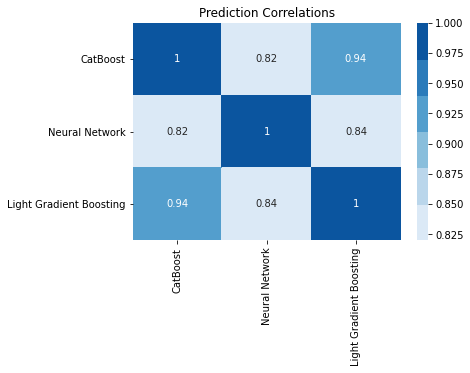

In [30]:
import seaborn as sns
sns.heatmap(results.corr(), annot = True, cmap=sns.color_palette("Blues"))
plt.title("Prediction Correlations")

In [31]:
final_pred_all = (final_pred_cbc + final_pred_nn + final_pred_lgbm) / 3

In [32]:
test["Outcome"] = final_pred_all

In [33]:
test[["Id", "Outcome"]].to_csv("submission_ensemble.csv", index=False)

# On top of using the ensemble scores, I could also post process my data, which I found out during my EDA process. Here, I do post processing to boost my ensemble score from 0.828 to 0.999 with near perfect accuracy. Here is my EDA and how I achieved it

In [34]:
submission = test[["Id", "Outcome"]].copy()
submission.head()

,Id,Outcome
0,76343,0.668826
1,66862,0.508602
2,69629,0.647287
3,50008,0.310675
4,66750,0.534126


#### There was a pattern to how Outcome is naturally ordered

Text(0.5, 1.0, 'Natural Order of Outcome Train Set')

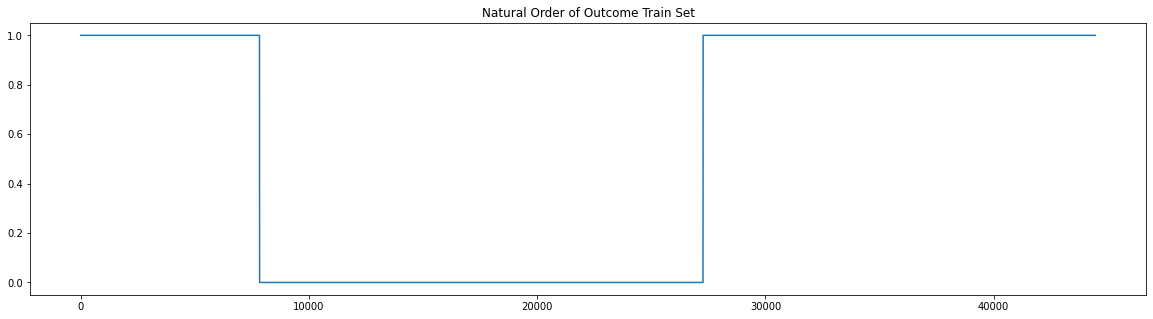

In [35]:
plt.figure(figsize = (20,5))
train = pd.read_csv("datasets/train.csv")
plt.plot(train.Outcome)
plt.title("Natural Order of Outcome Train Set")

Text(0.5, 1.0, 'Outcome Ordered by Id Train Set')

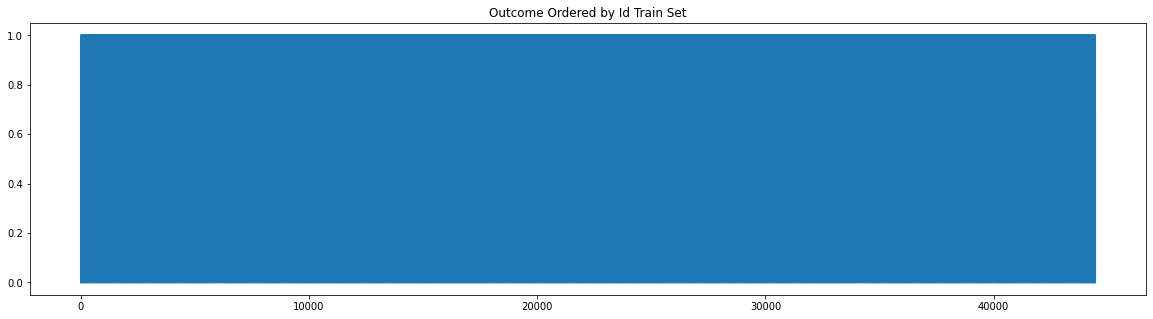

In [36]:
plt.figure(figsize = (20,5))
plt.plot(train.sort_values("Id").reset_index().Outcome)
plt.title("Outcome Ordered by Id Train Set")

#### Another pattern I observed, that IDs weren't 100% randomly ordered.

Text(0.5, 1.0, 'Outcome Ordered by Id Train Set (Subset)')

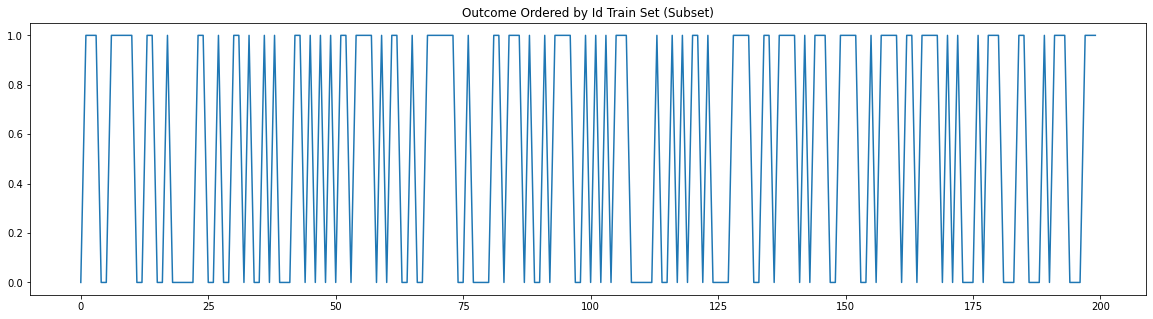

In [37]:
plt.figure(figsize = (20,5))
plt.plot(train.sort_values("Id").reset_index().iloc[:200].Outcome)
plt.title("Outcome Ordered by Id Train Set (Subset)")

Text(0.5, 1.0, 'Outcome Ordered by Id Test Set (Subset)')

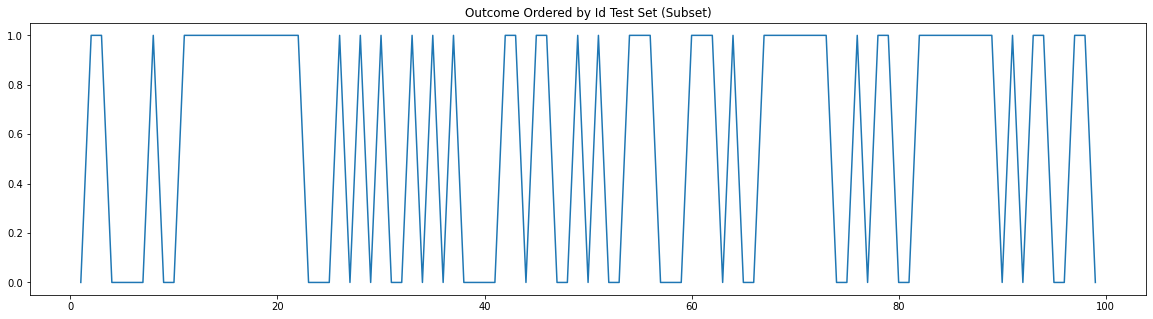

In [38]:
plt.figure(figsize=(20,5))
submission["Predicted_Vals"] = submission.Outcome.apply(lambda x: 1 if x > 0.5 else 0)
plt.plot(submission.sort_values("Id").reset_index().iloc[1:100].Predicted_Vals)
plt.title("Outcome Ordered by Id Test Set (Subset)")

#### Visualising the predicted probabilities from using the ensemble, I saw that there was the same pattern as the train set! I just had to get a rolling mean so that the scores could be separated to boost the auc score.

Text(0.5, 1.0, 'Predicted Probability of Outcome')

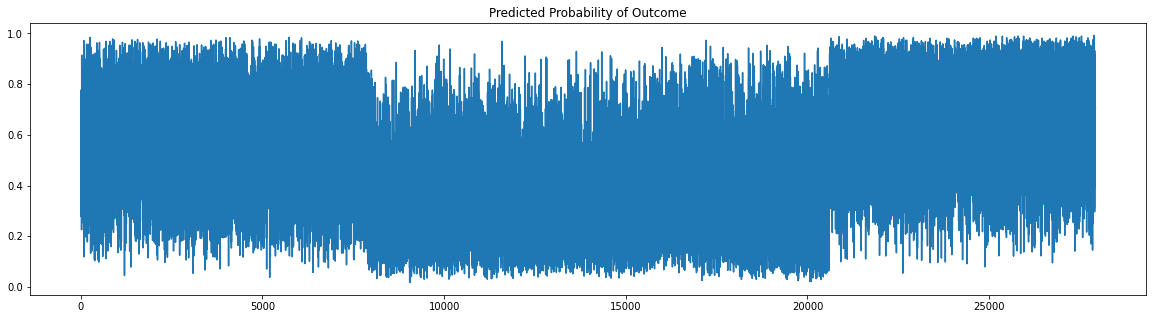

In [39]:
plt.figure(figsize=(20,5))
plt.plot(submission.Outcome)
plt.title("Predicted Probability of Outcome")

#### After applying a rolling mean, we can see that the predictions have been separated well!

Text(0.5, 1.0, 'Predicted Probability of Outcome (Rolling 70 mean)')

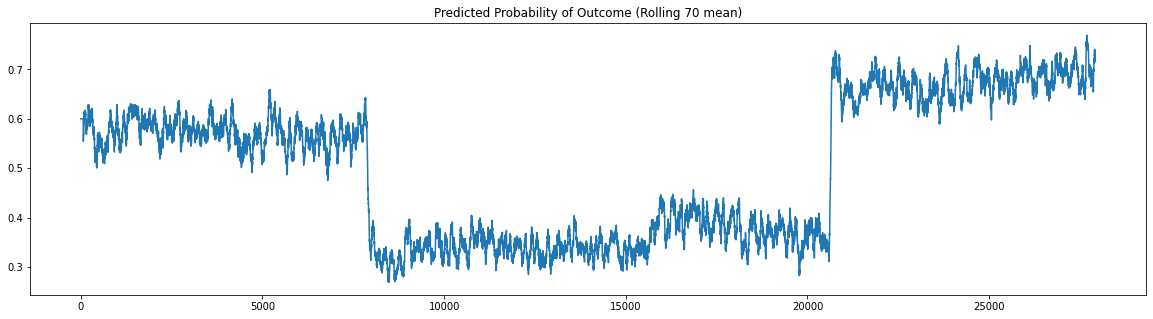

In [40]:
plt.figure(figsize=(20,5))
submission["Outcome"] = submission[["Outcome"]].rolling(70).mean().fillna(0.6).Outcome
plt.plot(submission["Outcome"])
plt.title("Predicted Probability of Outcome (Rolling 70 mean)")

In [41]:
submission[["Id", "Outcome"]].to_csv("submission_potential_leakage.csv", index=False)